# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 15:14 - loss: 0.6940

  23/1875 [..............................] - ETA: 4s - loss: 0.5829   

  45/1875 [..............................] - ETA: 4s - loss: 0.5040

  75/1875 [>.............................] - ETA: 3s - loss: 0.4466

 102/1875 [>.............................] - ETA: 3s - loss: 0.4155

 130/1875 [=>............................] - ETA: 3s - loss: 0.3928

 158/1875 [=>............................] - ETA: 3s - loss: 0.3755

 187/1875 [=>............................] - ETA: 3s - loss: 0.3610

 213/1875 [==>...........................] - ETA: 3s - loss: 0.3501

 241/1875 [==>...........................] - ETA: 3s - loss: 0.3401

 260/1875 [===>..........................] - ETA: 3s - loss: 0.3340

 289/1875 [===>..........................] - ETA: 3s - loss: 0.3257

 318/1875 [====>.........................] - ETA: 3s - loss: 0.3183

 347/1875 [====>.........................] - ETA: 2s - loss: 0.3117

 375/1875 [=====>........................] - ETA: 2s - loss: 0.3059

 404/1875 [=====>........................] - ETA: 2s - loss: 0.3004

 433/1875 [=====>........................] - ETA: 2s - loss: 0.2953

 463/1875 [======>.......................] - ETA: 2s - loss: 0.2905

 492/1875 [======>.......................] - ETA: 2s - loss: 0.2862

 521/1875 [=======>......................] - ETA: 2s - loss: 0.2821

 550/1875 [=======>......................] - ETA: 2s - loss: 0.2783

 579/1875 [========>.....................] - ETA: 2s - loss: 0.2748

 608/1875 [========>.....................] - ETA: 2s - loss: 0.2715

 637/1875 [=========>....................] - ETA: 2s - loss: 0.2683

 666/1875 [=========>....................] - ETA: 2s - loss: 0.2653

 695/1875 [==========>...................] - ETA: 2s - loss: 0.2625

 726/1875 [==========>...................] - ETA: 2s - loss: 0.2596

 755/1875 [===========>..................] - ETA: 2s - loss: 0.2570

 783/1875 [===========>..................] - ETA: 2s - loss: 0.2547

 812/1875 [===========>..................] - ETA: 1s - loss: 0.2523

 841/1875 [============>.................] - ETA: 1s - loss: 0.2501

 870/1875 [============>.................] - ETA: 1s - loss: 0.2479

 899/1875 [=============>................] - ETA: 1s - loss: 0.2458

 927/1875 [=============>................] - ETA: 1s - loss: 0.2439

 956/1875 [==============>...............] - ETA: 1s - loss: 0.2420

 985/1875 [==============>...............] - ETA: 1s - loss: 0.2401

1014/1875 [===============>..............] - ETA: 1s - loss: 0.2383

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2366

1072/1875 [================>.............] - ETA: 1s - loss: 0.2349

1101/1875 [================>.............] - ETA: 1s - loss: 0.2333

1130/1875 [=================>............] - ETA: 1s - loss: 0.2318

1160/1875 [=================>............] - ETA: 1s - loss: 0.2302

1184/1875 [=================>............] - ETA: 1s - loss: 0.2290

1213/1875 [==================>...........] - ETA: 1s - loss: 0.2275

1242/1875 [==================>...........] - ETA: 1s - loss: 0.2261

1272/1875 [===================>..........] - ETA: 1s - loss: 0.2247

1301/1875 [===================>..........] - ETA: 1s - loss: 0.2234

1329/1875 [====================>.........] - ETA: 0s - loss: 0.2222

1358/1875 [====================>.........] - ETA: 0s - loss: 0.2209

1387/1875 [=====================>........] - ETA: 0s - loss: 0.2197

1417/1875 [=====================>........] - ETA: 0s - loss: 0.2185

1447/1875 [======================>.......] - ETA: 0s - loss: 0.2173

1476/1875 [======================>.......] - ETA: 0s - loss: 0.2162

1505/1875 [=======================>......] - ETA: 0s - loss: 0.2151

1534/1875 [=======================>......] - ETA: 0s - loss: 0.2140

1564/1875 [========================>.....] - ETA: 0s - loss: 0.2129

1594/1875 [========================>.....] - ETA: 0s - loss: 0.2119

1627/1875 [=========================>....] - ETA: 0s - loss: 0.2107

1658/1875 [=========================>....] - ETA: 0s - loss: 0.2097

1686/1875 [=========================>....] - ETA: 0s - loss: 0.2088

1714/1875 [==========================>...] - ETA: 0s - loss: 0.2079

1742/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1767/1875 [===========================>..] - ETA: 0s - loss: 0.2062

1798/1875 [===========================>..] - ETA: 0s - loss: 0.2053

1826/1875 [============================>.] - ETA: 0s - loss: 0.2045

1851/1875 [============================>.] - ETA: 0s - loss: 0.2037

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2030


Epoch 2/5


   1/1875 [..............................] - ETA: 3s - loss: 0.1140

  30/1875 [..............................] - ETA: 3s - loss: 0.1096

  59/1875 [..............................] - ETA: 3s - loss: 0.1098

  88/1875 [>.............................] - ETA: 3s - loss: 0.1097

 112/1875 [>.............................] - ETA: 3s - loss: 0.1096

 140/1875 [=>............................] - ETA: 3s - loss: 0.1095

 160/1875 [=>............................] - ETA: 3s - loss: 0.1094

 185/1875 [=>............................] - ETA: 3s - loss: 0.1093

 214/1875 [==>...........................] - ETA: 3s - loss: 0.1092

 244/1875 [==>...........................] - ETA: 3s - loss: 0.1091

 273/1875 [===>..........................] - ETA: 2s - loss: 0.1090

 303/1875 [===>..........................] - ETA: 2s - loss: 0.1089

 332/1875 [====>.........................] - ETA: 2s - loss: 0.1088

 361/1875 [====>.........................] - ETA: 2s - loss: 0.1087

 390/1875 [=====>........................] - ETA: 2s - loss: 0.1086

 420/1875 [=====>........................] - ETA: 2s - loss: 0.1085

 449/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 473/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 499/1875 [======>.......................] - ETA: 2s - loss: 0.1083

 528/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 558/1875 [=======>......................] - ETA: 2s - loss: 0.1081

 585/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 615/1875 [========>.....................] - ETA: 2s - loss: 0.1079

 644/1875 [=========>....................] - ETA: 2s - loss: 0.1079

 673/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 702/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 731/1875 [==========>...................] - ETA: 2s - loss: 0.1076

 760/1875 [===========>..................] - ETA: 2s - loss: 0.1076

 788/1875 [===========>..................] - ETA: 1s - loss: 0.1075

 818/1875 [============>.................] - ETA: 1s - loss: 0.1074

 843/1875 [============>.................] - ETA: 1s - loss: 0.1073

 872/1875 [============>.................] - ETA: 1s - loss: 0.1073

 901/1875 [=============>................] - ETA: 1s - loss: 0.1072

 929/1875 [=============>................] - ETA: 1s - loss: 0.1071

 952/1875 [==============>...............] - ETA: 1s - loss: 0.1071

 980/1875 [==============>...............] - ETA: 1s - loss: 0.1070

1008/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1032/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1056/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1081/1875 [================>.............] - ETA: 1s - loss: 0.1068

1100/1875 [================>.............] - ETA: 1s - loss: 0.1068

1125/1875 [=================>............] - ETA: 1s - loss: 0.1067

1153/1875 [=================>............] - ETA: 1s - loss: 0.1066

1178/1875 [=================>............] - ETA: 1s - loss: 0.1066

1206/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1232/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1261/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1290/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1319/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1348/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1377/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1406/1875 [=====================>........] - ETA: 0s - loss: 0.1061

1435/1875 [=====================>........] - ETA: 0s - loss: 0.1061

1464/1875 [======================>.......] - ETA: 0s - loss: 0.1060

1494/1875 [======================>.......] - ETA: 0s - loss: 0.1060

1523/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1549/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1578/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1607/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1637/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1666/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1693/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1723/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1752/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1780/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1809/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1838/1875 [============================>.] - ETA: 0s - loss: 0.1054

1867/1875 [============================>.] - ETA: 0s - loss: 0.1053

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1053


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0967

  30/1875 [..............................] - ETA: 3s - loss: 0.0958

  58/1875 [..............................] - ETA: 3s - loss: 0.0963

  87/1875 [>.............................] - ETA: 3s - loss: 0.0965

 115/1875 [>.............................] - ETA: 3s - loss: 0.0967

 142/1875 [=>............................] - ETA: 3s - loss: 0.0968

 170/1875 [=>............................] - ETA: 3s - loss: 0.0968

 199/1875 [==>...........................] - ETA: 3s - loss: 0.0969

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0970

 258/1875 [===>..........................] - ETA: 2s - loss: 0.0970

 286/1875 [===>..........................] - ETA: 2s - loss: 0.0971

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0971

 344/1875 [====>.........................] - ETA: 2s - loss: 0.0971

 373/1875 [====>.........................] - ETA: 2s - loss: 0.0971

 401/1875 [=====>........................] - ETA: 2s - loss: 0.0971

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0971

 457/1875 [======>.......................] - ETA: 2s - loss: 0.0971

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0971

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0971

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0971

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0971

 601/1875 [========>.....................] - ETA: 2s - loss: 0.0971

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0971

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0971

 686/1875 [=========>....................] - ETA: 2s - loss: 0.0971

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0971

 744/1875 [==========>...................] - ETA: 2s - loss: 0.0971

 773/1875 [===========>..................] - ETA: 1s - loss: 0.0971

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0971

 829/1875 [============>.................] - ETA: 1s - loss: 0.0971

 858/1875 [============>.................] - ETA: 1s - loss: 0.0971

 885/1875 [=============>................] - ETA: 1s - loss: 0.0971

 914/1875 [=============>................] - ETA: 1s - loss: 0.0971

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0971

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0971

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0971

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0971

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0971

1087/1875 [================>.............] - ETA: 1s - loss: 0.0970

1116/1875 [================>.............] - ETA: 1s - loss: 0.0970

1143/1875 [=================>............] - ETA: 1s - loss: 0.0970

1172/1875 [=================>............] - ETA: 1s - loss: 0.0970

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0970

1226/1875 [==================>...........] - ETA: 1s - loss: 0.0970

1255/1875 [===================>..........] - ETA: 1s - loss: 0.0970

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0970

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0970

1340/1875 [====================>.........] - ETA: 0s - loss: 0.0970

1369/1875 [====================>.........] - ETA: 0s - loss: 0.0970

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0970

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0970

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0970

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0970

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0970

1535/1875 [=======================>......] - ETA: 0s - loss: 0.0970

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0970

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0970

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0970

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0970

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0970

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0970

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0970

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0970

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0970

1820/1875 [============================>.] - ETA: 0s - loss: 0.0970

1847/1875 [============================>.] - ETA: 0s - loss: 0.0970

1874/1875 [============================>.] - ETA: 0s - loss: 0.0970

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0970


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0952

  29/1875 [..............................] - ETA: 3s - loss: 0.0958

  57/1875 [..............................] - ETA: 3s - loss: 0.0964

  85/1875 [>.............................] - ETA: 3s - loss: 0.0963

 113/1875 [>.............................] - ETA: 3s - loss: 0.0963

 141/1875 [=>............................] - ETA: 3s - loss: 0.0963

 170/1875 [=>............................] - ETA: 3s - loss: 0.0963

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0962

 226/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 283/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 312/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 370/1875 [====>.........................] - ETA: 2s - loss: 0.0960

 399/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 488/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 604/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 744/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 772/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 800/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 827/1875 [============>.................] - ETA: 1s - loss: 0.0958

 856/1875 [============>.................] - ETA: 1s - loss: 0.0958

 885/1875 [=============>................] - ETA: 1s - loss: 0.0958

 914/1875 [=============>................] - ETA: 1s - loss: 0.0958

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1086/1875 [================>.............] - ETA: 1s - loss: 0.0958

1114/1875 [================>.............] - ETA: 1s - loss: 0.0958

1139/1875 [=================>............] - ETA: 1s - loss: 0.0958

1165/1875 [=================>............] - ETA: 1s - loss: 0.0958

1181/1875 [=================>............] - ETA: 1s - loss: 0.0958

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0958

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0958

1323/1875 [====================>.........] - ETA: 1s - loss: 0.0958

1353/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1823/1875 [============================>.] - ETA: 0s - loss: 0.0957

1852/1875 [============================>.] - ETA: 0s - loss: 0.0957

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0957


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0923

  32/1875 [..............................] - ETA: 3s - loss: 0.0946

  62/1875 [..............................] - ETA: 3s - loss: 0.0951

  92/1875 [>.............................] - ETA: 2s - loss: 0.0953

 121/1875 [>.............................] - ETA: 2s - loss: 0.0954

 152/1875 [=>............................] - ETA: 2s - loss: 0.0955

 183/1875 [=>............................] - ETA: 2s - loss: 0.0956

 213/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 244/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 335/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 385/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 470/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 584/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 611/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 637/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 660/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 683/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 742/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 766/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 795/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 820/1875 [============>.................] - ETA: 1s - loss: 0.0953

 846/1875 [============>.................] - ETA: 1s - loss: 0.0953

 875/1875 [=============>................] - ETA: 1s - loss: 0.0953

 905/1875 [=============>................] - ETA: 1s - loss: 0.0953

 934/1875 [=============>................] - ETA: 1s - loss: 0.0953

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 987/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1075/1875 [================>.............] - ETA: 1s - loss: 0.0952

1104/1875 [================>.............] - ETA: 1s - loss: 0.0952

1133/1875 [=================>............] - ETA: 1s - loss: 0.0952

1161/1875 [=================>............] - ETA: 1s - loss: 0.0952

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1248/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1277/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1364/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1393/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1840/1875 [============================>.] - ETA: 0s - loss: 0.0952

1870/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

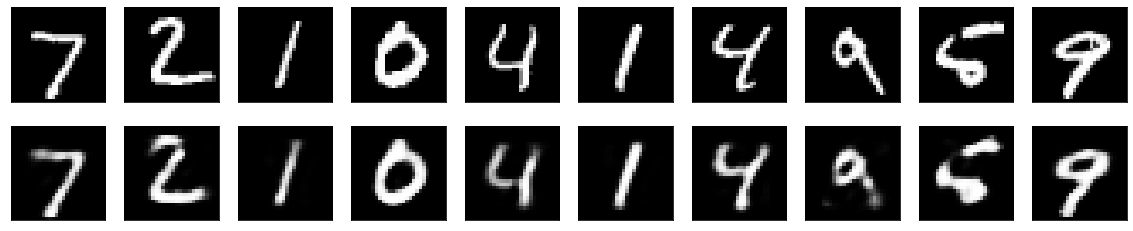

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
